# Power Spectral Analysis with X-ray data

In this tutorial, we will show you how to 

1. make a light curve out photon event data
2. make a light curve out of binned data
3. make a power spectrum out of a light curve
4. fit that power spectrum with various models

Note that this tutorial specifically covers data that consists of 
photons, that is, well-described by Poisson statistics. 
There will be another tutorial describing data with other statistics
(e.g. optical). 

## Imports

First, we'll do the necessary imports.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# I like seaborn for plots, but it's not a prerequesite.
try:
    import seaborn as sns
except ImportError:
    print("No seaborn. Plots will look less pretty!")

import numpy as np
import scipy.stats

from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum
from stingray.modeling.posterior import PSDPosterior
from stingray.modeling.parameterestimation import PSDParEst
from stingray.modeling.parametricmodels import Const, PowerLaw, PowerLawConst, Lorentzian
from stingray.modeling.parametricmodels import logmin

## set the random seed for numpy.random
np.random.seed(20151231)

## Making a Light Curve

First, we need to load some time series data and make a light curve out of it. In general, X-ray data comes in two flavours: either (1) time-tagged event data or (2) binned data. In the first case, the instrument records raw photon arrival times at the detector and saves a list of these arrival times. The photons generally obey the statistical description of an inhomogeneous Poisson process. Note that any data processing (e.g. removal of house-keeping data and barycentering of the photons) needs to be applied in advance; at this point, this package does not support instrument-specific data processing. 
In this case, the data is a single column of photon arrival times.

In the second case, either the instrument's time resolution is too big to resolve individual photons, or the data has been binned in the data processing. Again, the data follows Poisson statistics, the data will be in two columns: time stamps and the counts in a bin. 

### A light curve from photon event lists

Let's make some photon arrival time data. We'll make a flat light curve (constant mean count rate), which is really easy to do: 

In [2]:
## define a length for the light curve
tseg = 1000.0
## start time
tstart = 0
## end time
tend = tstart + tseg

## pick the number of Poisson counts in the entire segment
total_counts = np.random.poisson(100000.0)
print("Total counts: " + str(total_counts))

## distribute photons randomly throughough the time segment
photon_arrivals = np.random.uniform(tstart,tend, size=total_counts)

## sort photons in time
photon_arrivals = np.sort(photon_arrivals)


Total counts: 99229


Now we can make a light curve. We'll do this by calling the `make_lightcurve` method of the `Lightcurve` class. We will also need to define a time resolution `dt` of the resulting light curve. If the total length of the light curve is not an integer multiple of `dt`, then the last bit of the light curve will be cut off. 

By default, `make_lightcurve` will make a light curve that starts at the arrival time of the first photon and ends at the arrival time of the last photon. In practice, the instrument could have started observing before and finished observing after the arrival of the first and last photon, respectively. Thus, the method allows for the definition of a keyword `tstart` and a keyword `tseg` describing the start time and the total length of the light curve.

**Note**: Be careful with photon event lists from instruments with a relatively coarse time resolution. Some instruments (e.g. XMM-Newton) produce event lists from light curves with a low time resolution (of seconds or so). In these event lists, either all photon arrival times are set to the start time of the time bin it has been recorded in, or the photon arrival times have been artificially randomized within the bin. In the first case, artifacts in a Fourier-based timing analysis are likely at the beat frequencies between the time resolution chosen and the time resolution of the original data, though randomization effectively takes care of that problem. Randomized photon arrival times are easier to work with, though their time resolution remains that of the original light curve returned by the instrument. Making light curves with a shorter resolution is to be avoided in order to avoid edge effects due to the bin edges.

In [3]:
dt = 5.0
lc = Lightcurve.make_lightcurve(photon_arrivals, dt=dt, tstart=tstart, tseg=tseg)

The result is an instance of class `Lightcurve`:

In [4]:
lc.__dict__.keys()

dict_keys(['countrate', 'dt', 'tseg', 'time', 'tstart', 'counts', 'ncounts'])

The attribute `time` describes the time stamps of the light curve; the keywords `counts` and `countrate` are the counts per bin and the counts per second, respectively. `ncounts` contains the total number of counts, `tseg` and `dt` expose the input keywords.

Let's have a look what our light curve looks like in practice:

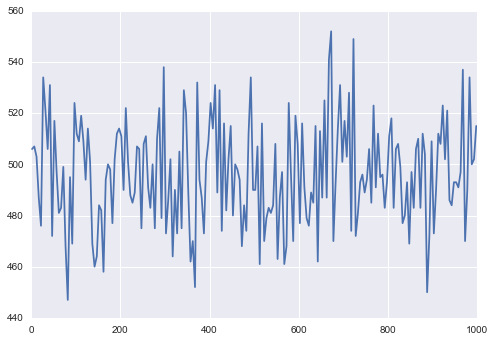

In [5]:
lc.plot()

We can also plot the count rate (counts/second) rather than counts/bin:

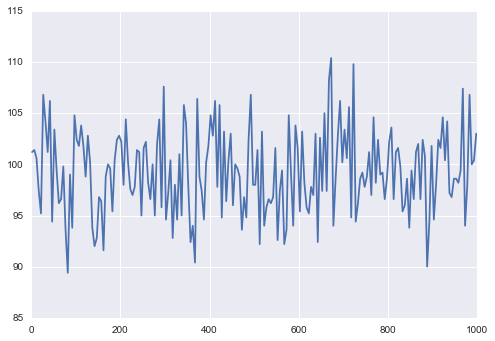

In [6]:
plt.plot(lc.time, lc.countrate)

### A light curve from counts or count rates

Let's also make a light curve from count data. In this case, the data will arrive in form of a list of time stamps and a list of associated counts in each bin.

This is effectively already a light curve. Instead of calling `make_lightcurve`, we can instantiate the `Lightcurve` object directly and just put the two lists into this object to allow for easy rebinning, creation of power spectra and further analysis. 

Let's make some Poisson data and show a 1000 second example:

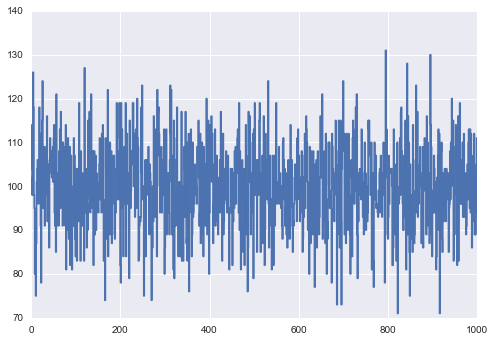

In [7]:
times = np.linspace(tstart, tstart+tseg, 1000)
counts = np.random.poisson(100, size=times.shape[0])

plt.plot(times, counts, linestyle="steps-mid")

Now we can make the light curve:

In [8]:
lc = Lightcurve(times, counts)

Sometimes, your data may not be in units of counts per bin, as above, but in counts per second, i.e. a _count rate_. This is allowed in Stingray, too. All you have to do is put the count rate into the `counts` keyword and set `input_counts=False` (it's `True` by default):

In [9]:
count_rate = counts/np.diff(times)[0]
lc = Lightcurve(times, count_rate, input_counts=False)

And that's all! For more information about light curves, see the respective tutorial in this repository.

### Rebinning light curves

Sometimes, you might want to re-bin a light curve to a different time resolution.
This is possible, too, by calling `rebin_lightcurve` on the `Lightcurve` object. This will return a new instance of class `Lightcurve`. During rebinning, the last bin may be cut off if the new bin width is not an integer multiple of the previous bin width, and the new bin width should be larger than the previous one.

The keyword `method` determines whether the counts in the new bins should be summed (`"sum"`) or averaged (`"average"` or `"mean"`).

In [10]:
dt_new = 10.0
lc_bin = lc.rebin_lightcurve(dt_new, method="sum")

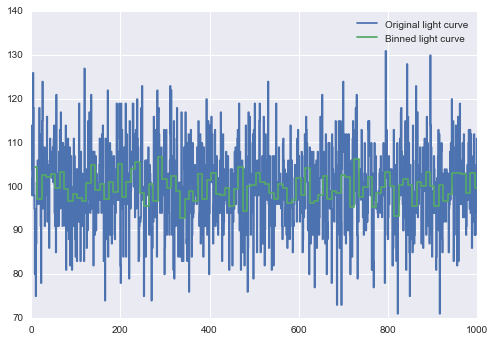

In [11]:
plt.plot(lc.time, lc.countrate, linestyle="steps-mid")
plt.plot(lc_bin.time, lc_bin.countrate, linestyle="steps-mid")
plt.legend(["Original light curve", "Binned light curve"])

## Making Power Spectra

Light curves only get you so far. Our next task is to make power spectra. 
This is possible by instantiating class `Powerspectrum`, which takes a `Lightcurve` object as input. This is not a detailed tutorial about Fourier analysis. [This](http://dare.uva.nl/record/1/426951) is a very good introduction into the topic.

It is possible to make power spectra in the most common normalizations: the standard [Leahy normalization](http://adsabs.harvard.edu/abs/1983ApJ...266..160L) and the [RMS normalization](http://adsabs.harvard.edu/abs/1991A%26A...245L..29B). In the first case, random Poisson noise will default to powers that are distributed following a $\chi^2_2$ distribution around a value of 2. In the latter case, the power spectrum will be normalized such that the square root of the sum of all powers equals that standard deviation of the light curve [CHECK WHETHER THIS IS TRUE!]. For details on power spectral statistics, please see the accompanying notebook in the same folder called `PowerSpectralStatistics`. 

In [12]:
ps = Powerspectrum(lc, norm="frac")

In [13]:
ps.__dict__.keys()

dict_keys(['nphots1', 'unnorm_power', 'n', 'meancounts1', 'nphots', 'norm', 'lc2', 'power', 'lc1', 'm', 'freq', 'meancounts2', 'df', 'nphots2'])

The power spectrum itself is in the keyword `freq` containing the list of frequencies and the keyword `power` containing the powers. `df` exposes the frequency resolution, `n` is twice the number of frequencies, `nphots` the total number of photons (useful in the normalization). `norm` exposes the normalization used, `unnorm_powers` are the raw squared Fourier amplitudes without normalization. Finally, `m` is a useful keyword defining the number of averaged powers in each bin. In this simple case above, this number is 1, however, this may be different when actually defining averaged power spectra or re-binned power spectra. Its importance lies when doing any sort of further analysis on these powers, since averaging powers changes the statistical distribution to be used in describing them.

For practical use, the rest of the above attributes are not needed.

Let's see what this spectrum looks like:

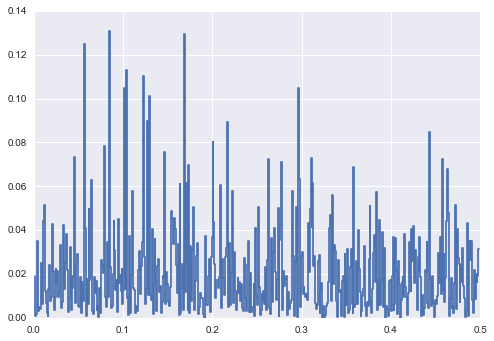

In [14]:
plt.plot(ps.freq, ps.power, linestyle="steps-mid")

This does not look particularly useful. The main reason is that both frequencies and powers extend over several orders of magnitude:

In [15]:
print("The smallest frequency is %.4f"%np.min(ps.freq))
print("The largest frequency is %.4f"%np.max(ps.freq))

print("The smallest power is %.4f"%np.min(ps.power))
print("The largest power is %.4f"%np.max(ps.power))


The smallest frequency is 0.0010
The largest frequency is 0.4985
The smallest power is 0.0000
The largest power is 0.1308


Instead, let's plot on a logarithmic scale in both axes:

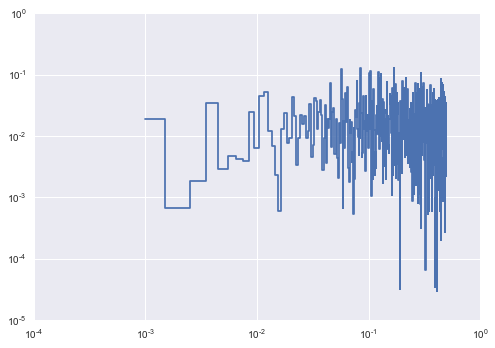

In [16]:
plt.loglog(ps.freq, ps.power, linestyle="steps-mid")

This looks more reasonable. We should also note that the zeroth frequency is already excluded, so no need to take care of that.

We can now use this object for further analysis.
For example, we can easily compute the fractional rms amplitude between two 
frequencies:

In [17]:
f_min, f_max = 0.01, 0.1
rms, rms_error = ps.compute_rms(f_min, f_max)

print("The fractional rms amplitude between %f and %f "%(f_min, f_max) + 
      "is %f +/- %f"%(rms, rms_error))

The fractional rms amplitude between 0.010000 and 0.100000 is 0.043518 +/- 0.087036


### Rebinning power spectra

Much like the light curve, we can also rebin the power spectrum. Similarly, the `rebin` method also exposes a keyword `method` describing whether the powers should be summed or averaged. It returns another object of type `Powerspectrum`.

In [18]:
df_new = 10*ps.df
ps_new = ps.rebin(df_new, method="mean")

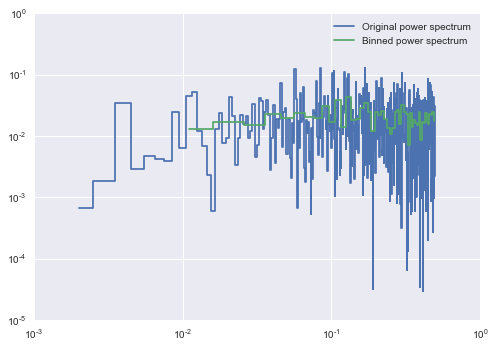

In [19]:
plt.loglog(ps.freq[1:], ps.power[1:], linestyle="steps-mid")
plt.loglog(ps_new.freq[1:], ps_new.power[1:], linestyle="steps-mid")
plt.legend(["Original power spectrum", "Binned power spectrum"])

The resulting binned power spectrum has a lower frequency resolution and lacks the lowest few powers (due to its smaller frequency resolution), but binning the powers results in a smaller standard deviation.

Unlike the light curve, the fact that the power spectrum extends over several orders of magnitude in both frequency and powers can make it useful to compute a logarithmically binned power spectrum. In this case, the width of each bin depends on the width of the previous bin and will be larger than that by a constant factor `f`, which can be specified as follows:

In [20]:
binfreq, binpower, binsamples = ps.rebin_log(f=0.01)

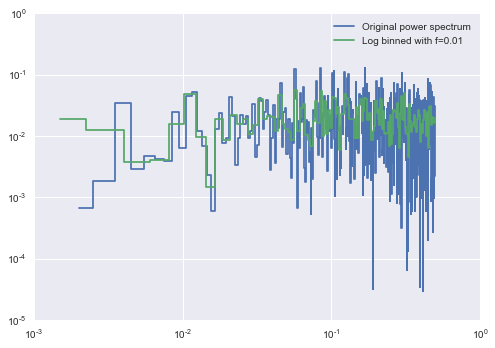

In [21]:
plt.loglog(ps.freq[1:], ps.power[1:], linestyle="steps-mid")
plt.loglog(binfreq, binpower, linestyle="steps-mid")
plt.legend(["Original power spectrum", "Log binned with f=0.01"])

As can be seen, the standard deviation becomes smaller at higher frequencies. This is due to the larger number of powers averaged at higher frequencies (because the bins are wider) compared to lower frequencies. The number of averaged frequencies per bin is recorded in the array `binsamples`, which is useful when computing power spectral statistics.

In [22]:
print(binsamples)

[0 1 3 2 2 2 2 2 2 2 2 3 2 2 2 3 2 2 3 2 3 2 2 3 2 3 3 2 3 2 3 3 2 3 3 3 3
 3 2 3 3 3 3 3 3 3 4 3 3 3 3 4 3 3 4 3 4 3 4 3 4 3 4 4 4 3 4 4 4 4 4 4 4 4
 4 4 5 4 4 4 5 4 5 4 5 4 5 5 5 4 5 5 5 5 5 5 5 6 5 5 5 6 5 6 5 6 6 5 6 6 6
 6 6 6 6 7 6 6 7 6 7 6 7 7 6 7]


## Frequentist Periodicity Detection in White Noise

Because the statistics of power spectra of Poisson data are fairly well known, detecting periodic signals in white noise (flat power spectrum) is a standard and reasonably simple task in the frequentist framework.

For Poisson data, the Fourier amplitudes are Gaussian random variables. Squaring the Fourier amplitudes implies that the resulting powers will follow a $\chi^2$ distribution with two degrees of freedom. Additionally, in the Leahy normalization, the powers are normalized such that they are distributed around a value of $2$. This means that the statistical distribution of the noise powers is predictable and can be utilized to find outliers (strong peaks in the power spectrum can be periodic or quasi-periodic signals). 

Note that it is not sufficient to compare a given power to a $\chi^2$ distribution. What we are in fact interested in is the probability of measuring the observed power or a higher one in the absence of a signal. This requires knowledge of the probability distribution of the powers in the presence of a signal. The basic framework for this computation is laid out in [Groth et al 1975](http://adsabs.harvard.edu/abs/1975ApJS...29..285G). 


In [23]:
from stingray.powerspectrum import classical_pvalue

First, we'll need to make a power spectrum in Leahy normalization. This is important! The function `classical_pvalue` only works on Leahy-normalized PSDs!

In [24]:
ps = Powerspectrum(lc, norm="leahy")

We'll find the maximum power in our power spectrum (note: exclude the zeroth power, since that in the Leahy normalization encodes the number of photons) and see what its significance is. In the case of averaged power spectra, we also need to give it the number of spectra averaged in order for it to use the correct probability distribution. If you have not averaged any spectra (and we have not in this example), set this number to 1:

In [25]:
maxpower = np.max(ps.power[1:])
print("The maximum power in the spectrum is %.3f"%maxpower)

# number of averaged spectra
nspec = 1

pval = classical_pvalue(maxpower, nspec)
print("The classical p-value for a power of %.3f and %i spectra "%(maxpower, nspec)+
      "is p = %.4f"%pval)

The maximum power in the spectrum is 13.051
The classical p-value for a power of 13.051 and 1 spectra is p = 0.0015


So we have a p-value of nearly $10^{-3}$ that the power measured above is due to noise alone, i.e. 15 in 10,000 times we may have noise that mimics an outlier like the one we found (no periodic signal whatsoever).

**Caveats:** The classical significances used below effectively compute $p$-values. $p$-values are a construct that measures the amount of probability enclosed in a region equal or higher to a critical value (in this case the observed value). It approximates the probability of seeing the observed value or higher under a null hypothesis (here: no signal present in the power spectrum). 

When quoting $p$-values, it is *absolutely essential to quote the number of trials*, that is, the number of times this test has been performed. To illustrate: a power with a $p$-value of $0.01$ has a chance probability of occuring in noise one out of one hundred times. If one tests a thousand powers, then ten of such occurrences are probable, which may well not correspond to true signals. Failure to include this type of correction may lead to significance Type I errors (detection of spurious signals in noise). 

Additionally, *$p$-values are extremely sensitive to the null hypothesis*. Here, the null hypothesis is pure white noise, i.e. a flat power spectrum derived from a light curve with absolutely no variability. As soon as any variability is present in the light curve, the assumptions made during the computation of the $p$-values no longer holds, again drastically increasing the chance of spurious detections.

Finally, instrumental effects may change the statistical distribution of powers. One example is dead time: this effect frequently occurs in photon counting detectors when high count rates are recorded. Many detectors have a short (of the order of a few micro-seconds) recovery time after the arrival of a photon before a second photon can be recorded. Any photon arriving during this recovery time might not be recorded and is lost. This leads to the instrument recording lower count rates than actually arrived, an effect that is stronger the higher the incident count rates are (because more photons will be lost). In practice, this leads to a change in the statistical distributions of powers. In the Leahy normalization, a deviation of the average noise powers from its expected value of $2$. Additionally, at high frequencies, the power spectrum is no longer flat and neighbouring powers are not independent, violating the assumptions of the significance calculations described above.
Corrections require very precise knowledge of the instrument coupled with extensive simulations. [This has been done](http://adsabs.harvard.edu/abs/1995ApJ...449..930Z), for example, for the *Rossi* X-ray Timing Explorer (RXTE). 

## Bayesian Periodicity Detection in White Noise

Under construction

## Modelling Power Spectra

X-ray binaries and other sources have complex variability patterns that cannot be easily characterized with flat white noise. In particular, at low frequencies, many show power law-like patterns called red noise. X-ray binaries also exhibit peaked structure that is not contained in one power, also called quasi-periodic oscillations. 

These patterns are generally modelled with a combination of different simple parametric models. Red noise is often modelled with a power law or broken power law, quasi-periodic oscillations often with Lorentzians or Gaussians.

`stingray` includes functionality to do this sort of modelling. Below, we will show how to use that functionality efficiently. Note that while it is possible to do standard maximum-likelihood analysis, a Bayesian approach with appropriately defined priors is recommended. We will concentrate on this approach, but point out how to perform likelihood maximization where appropriate. For an introduction into Bayesian statistics and the associated philosophical and practical differences, you might want to look at http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/ or watch the introductory lecture here: https://www.youtube.com/watch?v=KB_8s3HsBfc .

What follows is a quick intro for the impatient, followed by a more in-depth introduction to show how to 

1. define parametric models
2. define posteriors and likelihood functions
3. perform optimization
4. perform Markov Chain Monte Carlo (MCMC) sampling

### Parametric Modelling for the Impatient

First, define a parametric model. `stingray` has the most common models pre-defined for easy computation. 


In [77]:
pl = PowerLaw()


The model has two parameters: the power law index `alpha` and the natural log of the amplitude:

In [27]:
pl.parnames

['alpha', 'amplitude']

In [28]:
times = np.linspace(1, 10, 10)
m = pl(times, 2.0, 3.0)

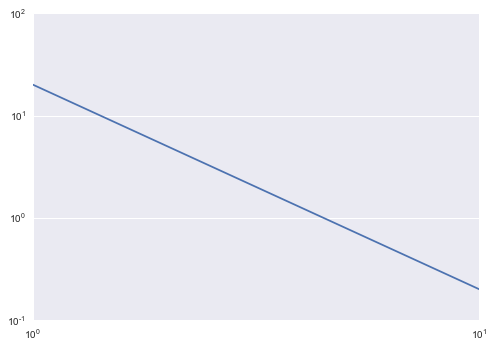

In [29]:
plt.loglog(times, m)

More often than not, we need a combination of more than one model. In the case of the power law and broken power law, `stingray` pre-defines models that also include a constant background level, as is usually the case in power spectra:

In [30]:
plc = PowerLawConst()

In [31]:
plc.parnames

['alpha', 'amplitude', 'const']

This model has an additional parameter defining the natural log of the constant background level:

(0.1, 10000.0)

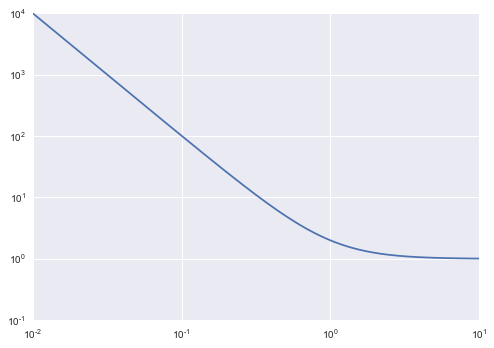

In [32]:
x = np.linspace(0.01, 10, 1000)
m = plc(x, 2.0, 0.0, 1.0)

plt.loglog(x, m)
plt.ylim(0.1, 10000.)

We can combine more models using the `CombinedModel` class:

### Defining Parametric models

`stingray` includes a framework for defining parametric models, with the most relevant already pre-defined. In general, all parametric models are subclasses of the superclass `ParametricModel` in `parametricmodels.py`. This superclass defines the basic structure and attributes that each model must have. Most importantly, one must define the parameters `npar` for the number of parameters and `name` with a string defining the model name. Optionally, it is possible to define a list of strings `parnames`, which will contain the names of individual parameters for easier visualization later.

Each subclass of `ParametricModel` must define a method `func` which contains the parametric function definition and takes the parameters as input.

For an example, consider the class `Const` in `parametricmodels.py`. Let's instantiate an instance of this model:

In [33]:
c = Const()

In [34]:
c.__dict__.keys()

dict_keys(['parnames', 'name', 'npar'])

In [35]:
print("Name: " + c.name)
print("Number of parameters: %i"%c.npar)
print("Parameter names: " + str(c.parnames))


Name: const
Number of parameters: 1
Parameter names: ['amplitude']


This model has a name `const` and one parameter named `amplitude`. 

We can call its function definition to show what the model looks like for certain time stamps:

In [36]:
times = np.linspace(0,10, 10)
c.func(times, 2.0)

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])

Obviously, since this model defines a constant function, it will be the value of the parameter `amplitude` at all times, so this isn't very interesting.
Note that we can also simply call the instance itself instead of its `func` method to get the same, making it easier to work with in practice:

In [37]:
counts = c(times, 2.0)

In [38]:
counts

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])

### Defining Priors For Parametric Models

Bayesian analysis requires the definition of prior probability distributions for its parameters. `stingray` pre-defines reasonable (for standard power spectral analysis), but fairly broad priors for the parameters of its pre-defined models. In practice, it might be more useful to define priors appropriate for a specific analysis problem. In this case, the easiest solution is to sub-class the relevant class with new priors.

When instantiating a `ParameterClass` object or one of its subclasses with no parameters, no prior will be defined, and whenever trying to follow-up with a Bayesian analysis, this will result in an error.

Definiting priors is a really good idea. For example, hard boundaries on the parameters based on physical knowledge of the system can be translated into a constant prior between a minimum and maximum parameter. On the other hand, in Leahy normalization, we can be fairly certain that the noise level should be close to a value of $2$, so a normal distribution with an appropriate width might be a good choice. 
If the data is informative, that information will overwhelm the prior predictions even when they are very wrong. If the prior information is reasonably good, it will make the conclusions of the analysis stronger.

In stingray, we define priors on **models**. That is, each model component has its own set of priors attached to it. By default, we've picked a few priors that are useful for PSD analysis. In practice, the easiest solution to implementing new priors is to subclass any of the classes in `parametricmodels.py`.

So how do we define priors on a model? Here's an example. Let's define a constant model for a light curve with no variability. By default, the prior is a normal distribution. The hyperparameters of this distribution, we have to define ourselves. You can find the details of the default distributions and the corresponding hyperparameters in the documentation of each class. So let's define a model with a prior:


In [39]:
hyperpars = {"a_mean": 2.0, "a_var":0.1}

In [40]:
c = Const(hyperpars=hyperpars)

The object `c` now has a function `logprior` that returns the prior of the model for a given parameter:

In [41]:
print(c.logprior(2.0))
print(c.logprior(1000.0))

1.38364655979
-1e+16


Obviously, a value of $2$ has a high probability density. Conversely, a value of $1000$ leads to a very small prior, as it should, since this value is very improbable given the proposed normal distribution.

Let's say you want a uniform distribution instead of a normal for the prior. When doing this, make sure your prior is properly normalized so that the integral of the probability density function equals $1$. Here's some example code for how to subclass `Const` in order to define a new class with a new prior:

In [42]:

class ConstUniformPrior(Const):
    
    def set_prior(self, hyperpars):
        """
        Set a uniform prior for the constant model.

        Parameters:
        -----------
        a_min: float
            Lower bound of the uniform distribution
        a_max: float
            Upper bound of the uniform distribution
        """

        a_min = hyperpars["a_min"]
        a_max = hyperpars["a_max"]

        def logprior(a):

            assert np.isfinite(a), "A must be finite."
            p_a = (a >= a_min and a <= a_max)/(a_max-a_min)

            #pp = scipy.stats.norm.pdf(a, a_mean, a_var)
            if p_a == 0.0:
                return logmin
            else:
                return np.log(p_a)

        self.logprior = logprior


And that should be all: let's now define an object from the new class and see whether the prior works:

In [43]:
hyperpars = {"a_min":1.0, "a_max":3.0}
cu = ConstUniformPrior(hyperpars=hyperpars)

In [44]:
print(cu.logprior(2.0))
print(cu.logprior(5.0))

-0.69314718056
-1e+16


Again, the logprior is finite for a value of $2$, which lies well within the uniform prior we defined. For a value of $5$, outside the bounds defined by the uniform prior, we get a prior of zero, which in practice translates to a very small number instead (to avoid numerical errors in the logarithm when the prior goes towards zero).

## Maximum Likelihood and Maximum-A-Posteriori Estimates

Now that we can define models, we'd like to use these models to try and represent our data with them. 
Without defining priors, one can use optimization algorithms to find the maximum of the likelihood distribution. 
When priors are defined, it is possible to use the same algorithm to try and find the maximum of the posterior 
probability distribution function, leading to a maximum-a-posteriori estimate. 

In order to demonstrate how this works, let's first make some fake data to use:

In [45]:
hyperpars = {"alpha_min":1.0,
            "alpha_max":5.0, 
            "amplitude_min":-10,
            "amplitude_max":10.0,
            "a_mean":2.0,
            "a_var":0.1}

plc = PowerLawConst(hyperpars=hyperpars)

print("true_params are " + str(plc.parnames))
true_pars = [2.0, 3.0, 2.0] 

x = np.linspace(0.01, 100, 2000)
ymodel = plc(x, *true_pars)

ydata = np.random.exponential(size=ymodel.shape[0])*ymodel

ps = Powerspectrum()
ps.freq = x
ps.power = ydata
ps.df = ps.freq[1]-ps.freq[0]
ps.nphots = ps.power[0]
ps.n = int(2*x.shape[0])
ps.m = 1

true_params are ['alpha', 'amplitude', 'const']


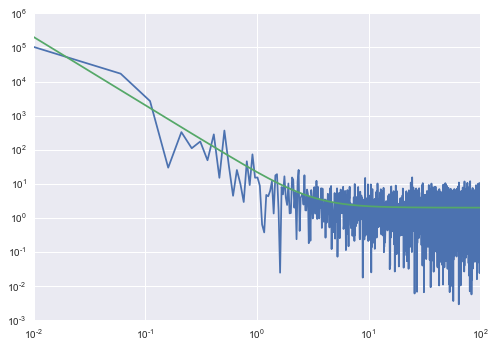

In [46]:
plt.loglog(x, ydata)
plt.loglog(x, ymodel)

Now we can try to model this data.

First, let's define the posterior distribution. `posterior.py` defines base classes and subclasses for the most 
common types of data. Each `Posterior` subclass defines a likelihood depending on the statistical properties of 
the data in question. For power spectra in particular, the subclass `PSDPosterior`, is particularly relevant, defining an exponential likelihood appropriate for Fourier powers. 

`PSDPosterior` takes a `Powerspectrum` object with the data and a `ParametricModel` subclass object with the model as an input. 


In [47]:
lpost = PSDPosterior(ps=ps, model=plc)

We can access the log-likelihood via the `loglikelihood` method:

In [48]:
lpost.model.npar

3

In [49]:
test_pars = [2.0, 3.0, 2.0]
lpost.loglikelihood(test_pars)

-3552.1864213658482

Similarly, we can access the prior via `logprior`:

In [50]:
lpost.logprior(test_pars)

-2.9983800748845084

And the posterior via `logposterior` or the class's `__call__` method:

In [51]:
lpost.logposterior(test_pars)

-3555.1848014407328

In [52]:
lpost(test_pars)

-3555.1848014407328

Cool! We can now do this for a large grid of parameters and find the maximum of that grid. But that isn't very efficient, especially not in high dimensions. So we can either (1) optimize and find the maximum of the distribution, or (2) cleverly sample the distribution.

Both are possible in stingray. We'll do the optimization part first. To do this, use the methods available in `regression.py`. Again, there is a superclass that allows for the flexible definition of other models. For power spectra, there's a class pre-defined called `PSDRegression`. This class will build the `PSDPosterior` object for you, but I thought I'd show the code, which might be useful for other uses.

Instantiate this object with a `Powerspectrum` object, and optionally with a `scipy.optimize` minimization algorithm (default choice is `L-BFGS-B`), and a boolean flag that sets whether to use the likelihood or the posterior for maximization:

In [53]:
## instantiate the object
fitspec = PSDParEst(ps, max_post=False)

## define a initial parameter set as a starting point 
## for the fitting algorithm
pars = [1.0, 5.0, 0.1]

## do the fit
fitparams = fitspec.fit(plc, pars)

The result is an object of class `RegressionResults`, which allows for easy extraction of key results of the optimization:

In [54]:
fitparams.__dict__.keys()

dict_keys(['model', 'sobs', 'maxind', 'merit', 'ssd', 'neg', 'maxfreq', 'p_opt', 'maxpow', 'err', 'mfit', 'dof', 'bic', 'deviance', 'result', 'cov', 'sexp', 'aic'])

In [55]:
## print parameters at the maximum likelihood:
print(fitparams.p_opt)

## print the errors on the parameters from the inverse Hession
print(fitparams.err)

## print the covariance matrix
print(fitparams.cov)

## print the value of the likelihood function at the optimum
print(fitparams.result)

## print the model used
print(fitparams.model)

## print the Akaike Information Criterion
print(fitparams.aic)

## print the Bayesian Information Criterion
print(fitparams.bic)

[ 2.06056817  2.95268102  1.98791356]
[ 0.1290907   0.14612589  0.05077274]
[[ 0.01666441  0.00023696  0.00166067]
 [ 0.00023696  0.02135277 -0.00125753]
 [ 0.00166067 -0.00125753  0.00257787]]
3551.9238801121683
3557.9238801121683
3574.72658749


As we can see, the optimization worked pretty well:

In [56]:
print(true_pars)
print(fitparams.p_opt)

[2.0, 3.0, 2.0]
[ 2.06056817  2.95268102  1.98791356]


The result of the optimization yields values that are close to the "true" parameters used to create the mock data. The differences are easily explained by the noise introduced when sampling from the $\chi^2$ distribution.

Instead of constantly calling `print` on a lot of individual results, there is a helper function that prints an overview of the results:

In [57]:
fitparams.print_summary(lpost)

The best-fit model parameters plus errors are:
0) Parameter alpha: 2.060568.5 +/- 0.129091.5f
1) Parameter amplitude: 2.952681.5 +/- 0.146126.5f
2) Parameter const: 1.987914.5 +/- 0.050773.5f


Fitting statistics: 
 -- number of data points: 2000
 -- Deviance [-2 log L] D = 7103.847760.3
 -- The Akaike Information Criterion of the model is: 3557.9238801121683.
 -- The Bayesian Information Criterion of the model is: 3574.72658749.
 -- The figure-of-merit function for this model  is: 1960.103330.5f and the fit for 1997 dof is 0.981524.3f
 -- Summed Residuals S = -139711.904816.5f
 -- Expected S ~ 12000.000000.5 +/- 154.919334.5
 -- merit function (SSE) M = 1960.103330.5f 




That looks more readable and takes less time!

The Bayesian maximum-a-posteriori (MAP) version works exactly analogously to the maximum likelihood version:

In [58]:
## instantiate the object
fitspec = PSDParEst(ps, max_post=True)

## define a initial parameter set as a starting point 
## for the fitting algorithm
pars = [2.0, 3.0, 1.9]

## do the fit
fitparams = fitspec.fit(plc, pars)

In [59]:
print(fitparams.p_opt)
print(fitparams.result)

[ 2.06212641  2.95155882  1.99019681]
3554.928185178937


The result is pretty close, since we've chosen pretty uninformative priors, aside from that on the noise level. 
Note that for both optimization routines, the outcome is quite sensitive to the starting conditions. Picking a starting parameter set that is very far from the "true" underlying parameters that produced the data can lead to (1) the optimization not concluding successfully or alternatively (2) the algorithm getting stuck in local minima. 

For deriving more robust results, it is recommended to run a grid of starting parameters and infer how robust the parameters at the inferred maximum are with respect to the starting parameters. 

## Markov Chain Monte Carlo Sampling

Optimization is efficient and straightforward. However, it can only return a (hopefully global) optimum and a lower bound on the errors on the parameters from the inverse Hessian. The latter will only be close to the real errors on the parameters if the likelihood or posterior is close to Gaussian and the algorithm has indeed found the global optimimum.

For characterizing more complex distributions, it may be more informative to sample from the posterior distribution and estimate the mode of the posterior (i.e. the global optimum) and errors on that estimate from there, or quote the posterior distribution itself without computing summaries of it (this strongly depends on the dimensionality of the problem). One popular approach to sampling the posterior is Markov Chain Monte Carlo (MCMC). An introduction to MCMC is beyond this tutorial, but there are many helpful resources on the internet available. MCMC produces one (or many) chains of parameter sets, where each parameter set in the chain only depends on the previous values of the parameters as well as a sampling distribution. At each step in the chain, a new parameter set is generated from a combination of the previous parameter set, modified using a jumping distribution that moves the parameters to new values. 
If the posterior of the new parameter set is larger than that of the previous parameter set, the new parameter set will be added to the chain. If it is smaller, then the new parameter set will be accepted with a probability equal to the ratio of the two posteriors. This way, one will build up a sample of parameter sets that is denser in regions of high posterior probability and less dense in regions of low posterior probability. In fact, under some reasonable assumptions as well as infinite sampling time, it can be proved that the Markov chain converges towards the true posterior. One important thing to point out is that for this approach, definition of a posterior distribution is absolutely **required**. It is not possible to use MCMC sampling self-consistently on a likelihood function!

However, note that this approach isn't without risks, either. If the posterior is very peaked and narrow, and the starting point of the Markov chain is far away, then it is possible that it will not reach regions of high probability in finite time. Similarly, multi-modal posteriors might not be explored if the jumping distribution is too narrow. If the chain isn't evolved for long enough, it might not reach a steady state where it truly samples from the posterior, skewing the results derived from the sample.

It isn't possible to fix any of these problems entirely. Different algorithms are fairly good at various problems, and there are some ways to evaluate the performance of a Markov chain. For `stingray`, we will not write our own implementation, but build on existing, stable and robust code to do the sampling for us.

Note: this requires installation of the package `emcee`.

In [60]:
lpost.model

In [61]:
fitparams.p_opt

array([ 2.06212641,  2.95155882,  1.99019681])

In [62]:
lpost

**Note to self**: multi-threading does not work!

In [63]:
fitspec.sample(lpost, fitparams.p_opt, nwalkers=1000, niter=1000, burnin=300, threads=1)

Chains too short to compute autocorrelation lengths.
-- The acceptance fraction is: 0.644998.5
R_hat for the parameters is: [ 0.0178747   0.02442135  0.00190222]
-- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

theta[0] 	 2.09308572842	0.133757968896	1.71441968985	1.81128685658

theta[1] 	 2.95127531417	0.156345188442	2.43276282321	2.58250865939

theta[2] 	 1.99327425446	0.0436345516966	1.85452587575	1.89287708428



In [64]:
import emcee

In [65]:
ndim = len(fitparams.p_opt)

In [66]:
res = fitparams

In [67]:
nwalkers = 100
burnin = 30
niter = 100

In [68]:
p0 = np.array([np.random.multivariate_normal(res.p_opt, res.cov) for
               i in range(nwalkers)])


In [69]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost, args=[False],
                                threads=1)


In [70]:
pos, prob, state = sampler.run_mcmc(p0, burnin)


In [71]:
sampler.reset()


In [72]:
pos, prob, state = sampler.run_mcmc(pos, niter, rstate0=state)


In [75]:
sampler.acor

AutocorrError: The chain is too short

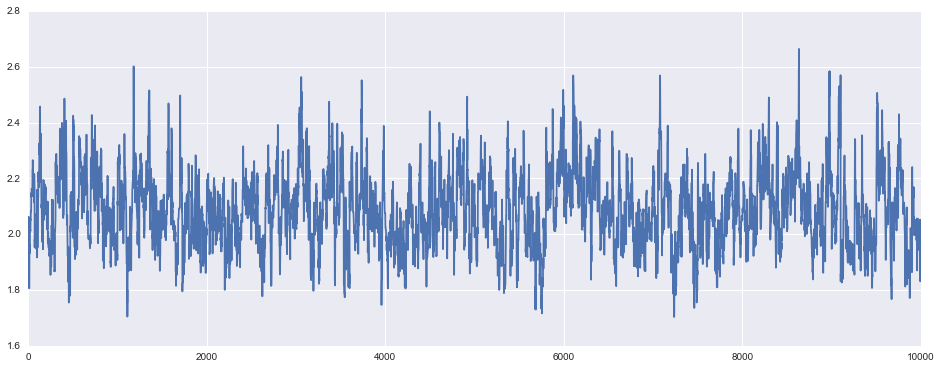

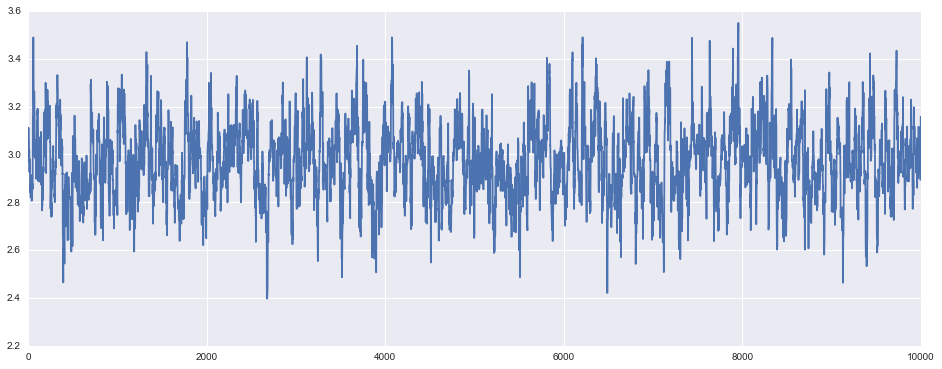

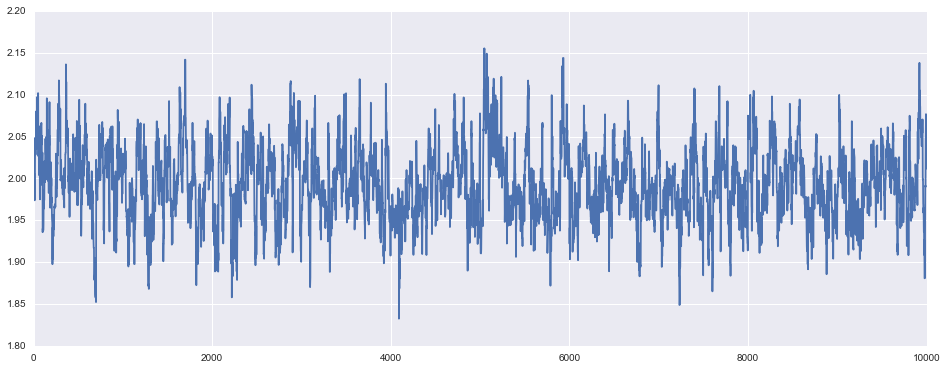

In [73]:
for i in range(sampler.flatchain.shape[1]):
    plt.figure(figsize=(16,6))
    plt.plot(sampler.flatchain[:,i])

In [74]:
sampler.acor

AutocorrError: The chain is too short

In [ ]:
emcee.autocorr.AutocorrError